## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [106]:
# from google.colab import drive
# drive.mount('/content/drive')

# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

In [107]:
# df = pd.read_csv('/content/drive/My Drive/Data/amazon.csv.gz')
df = pd.read_csv('../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ACTION', ylabel='count'>

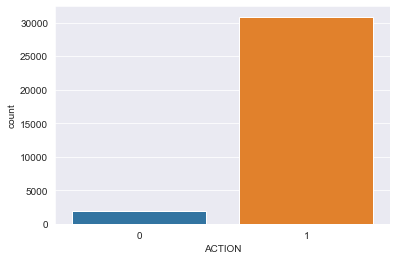

In [108]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [109]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [110]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [111]:
knn1 = KNeighborsClassifier(n_neighbors= 5, p=2)
knn1.fit(X_train, y_train)
y_pred = knn1.predict(X_test)

print(classification_report(y_test, y_pred))
cm

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216


array([[   41,  1493],
       [  147, 24535]], dtype=int64)

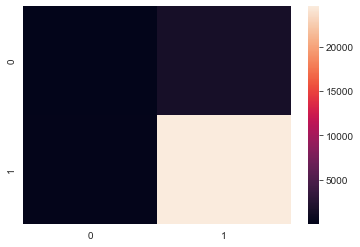

In [112]:
sns.heatmap(cm)
plt.show()

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [113]:
p_arr = [1, 2, 4, 6]
for p in p_arr:
    knn = KNeighborsClassifier(n_neighbors=10, p=p)
    scores = cross_val_score(knn, X_train, y_train, cv=5)
    print(f'p={p}: Mean={np.mean(scores)}, Std deviation={np.std(scores)}')

p=1: Mean=0.9443005455889975, Std deviation=0.0009519030430808572
p=2: Mean=0.9446056561915908, Std deviation=0.0007684587110299395
p=4: Mean=0.9444532173447225, Std deviation=0.0008710708423343614
p=6: Mean=0.9441478738332721, Std deviation=0.0005552549103419756


Метрика достигает максимума при значении p=2

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [114]:
data = pd.DataFrame(index=df.index)

kfold = KFold(n_splits=3)

for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    for train_index, val_index in kfold.split(df):
        train_df_fold, val_df_fold = df.iloc[train_index], df.iloc[val_index]
    
        col_counts = train_df_fold.groupby(col_name).size()
    
        col_successes = train_df_fold[train_df_fold['ACTION'] == 1].groupby(col_name).size()
    
        col_smoothed_ratio = (col_successes + 1) / (col_counts + 2)
    
        data.loc[val_df_fold.index, col_name + '_counts'] = val_df_fold[col_name].map(col_counts)
        data.loc[val_df_fold.index, col_name + '_successes'] = val_df_fold[col_name].map(col_successes)
        data.loc[val_df_fold.index, col_name + '_ratio'] = val_df_fold[col_name].map(col_smoothed_ratio)

data.fillna(0, inplace=True)
data['ACTION'] = df['ACTION']
data

,RESOURCE_counts,RESOURCE_successes,RESOURCE_ratio,MGR_ID_counts,MGR_ID_successes,MGR_ID_ratio,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_1_successes,ROLE_ROLLUP_1_ratio,ROLE_ROLLUP_2_counts,...,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_DESC_successes,ROLE_FAMILY_DESC_ratio,ROLE_FAMILY_counts,ROLE_FAMILY_successes,ROLE_FAMILY_ratio,ROLE_CODE_counts,ROLE_CODE_successes,ROLE_CODE_ratio,ACTION
0,1.0,1.0,0.666667,31.0,31.0,0.969697,14208.0,13488.0,0.949261,2961.0,...,4607.0,4307.0,0.934693,7299.0,6890.0,0.943843,2387.0,2312.0,0.968188,1
1,19.0,18.0,0.904762,5.0,5.0,0.857143,14208.0,13488.0,0.949261,2633.0,...,7.0,7.0,0.888889,881.0,829.0,0.939977,54.0,53.0,0.964286,1
2,1.0,1.0,0.666667,1.0,1.0,0.666667,129.0,117.0,0.900763,129.0,...,22.0,20.0,0.875000,1835.0,1661.0,0.904736,877.0,775.0,0.882821,1
3,0.0,0.0,0.000000,45.0,45.0,0.978723,14208.0,13488.0,0.949261,2633.0,...,811.0,776.0,0.955720,7299.0,6890.0,0.943843,3097.0,2852.0,0.920620,1
4,3.0,3.0,0.800000,4.0,4.0,0.833333,184.0,173.0,0.935484,96.0,...,11.0,10.0,0.846154,239.0,196.0,0.817427,60.0,51.0,0.838710,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,39.0,34.0,0.853659,18.0,18.0,0.950000,14329.0,13608.0,0.949620,2923.0,...,842.0,806.0,0.956161,7355.0,6946.0,0.944271,3104.0,2869.0,0.924018,1
32765,0.0,0.0,0.000000,5.0,5.0,0.857143,454.0,435.0,0.956140,454.0,...,3.0,3.0,0.800000,137.0,135.0,0.978417,10.0,10.0,0.916667,1
32766,114.0,110.0,0.956897,3.0,3.0,0.800000,14329.0,13608.0,0.949620,1794.0,...,1.0,1.0,0.666667,51.0,49.0,0.943396,2.0,2.0,0.750000,1
32767,5.0,5.0,0.857143,13.0,9.0,0.666667,167.0,128.0,0.763314,155.0,...,166.0,146.0,0.875000,867.0,758.0,0.873418,257.0,236.0,0.915058,1


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

Mean=0.9420115173429757, Std deviation=0.0014383133666802954
              precision    recall  f1-score   support

           0       0.32      0.03      0.05      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.63      0.51      0.51     26216
weighted avg       0.91      0.94      0.92     26216


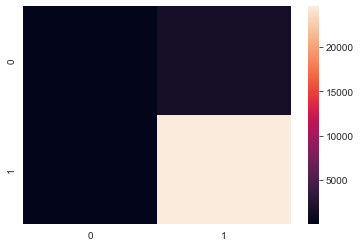

In [125]:
knn2 = KNeighborsClassifier(n_neighbors=10, p=2)

X2 = data.drop(['ACTION'], axis=1)
y2 = data['ACTION']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=0.8)

knn2.fit(X2_train, y2_train)

scores = cross_val_score(knn2, X2_train, y2_train, cv=5)
print(f'Mean={np.mean(scores)}, Std deviation={np.std(scores)}')

y2_pred = knn2.predict(X2_test)

print(classification_report(y2_test, y2_pred))

cm2 = confusion_matrix(y2_test, y2_pred)

sns.heatmap(cm2)
plt.show()

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [ ]:
df_combo = df.copy()
# ТУТ ВАШ КОД

In [ ]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    # тут ваш код

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [ ]:
df_target = df.copy()

In [ ]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    # тут ваш код

Сравните результаты. 

Какой недостаток есть у target encoding?

